# <center><h1>Convolutional Neural Networks (CNN) for Image Classification</h1></center>

<center><img src="../Images/SampleCNN.png" alt="CNN Architecture" /></center>

## Overview
CNNs are specialized neural networks designed for processing grid-like data, particularly images. They use convolution operations to automatically learn spatial hierarchies of features from input data.

### Key Characteristics
- Uses convolution operations to detect features
- Maintains spatial relationships in data
- Parameter sharing reduces model complexity
- Translation invariant (can detect features anywhere in image)

### Process Flow
1. Input image is processed through convolutional layers
2. Each layer detects increasingly complex features
3. Pooling layers reduce spatial dimensions
4. Final dense layers perform classification
5. Output predicts image class probabilities

## Helpful Links
- [Working with CNNs](https://www.tensorflow.org/tutorials/images/cnn)
- [Image Classification](https://www.tensorflow.org/tutorials/images/classification)

## Implementation Approaches
We will explore three implementations with increasing complexity:

1. **Basic CNN Model**
   - Few convolutional layers
   - Simple dense output layer
   - Basic configuration
   
2. **Complex CNN Model**
   - Multiple convolutional layers
   - Batch normalization
   - Dropout for regularization
   
3. **Testing Multiple Models**
   - Functions to build and train models
   - Functions to evaluate models
   - Compare performance of different models
   - Visualize results

## Implementation Steps
1. **Data Evaluation**
   - Analyze image characteristics
   - Check class distribution
   - Examine sample images
   
2. **Dataset Definition**
   - Load and preprocess images
   - Split into training and testing sets
   - Apply data augmentation

3. **Model Architecture**
   - Define convolutional layers
   - Add pooling layers
   - Configure dense layers

4. **Model Training**
   - Compile with appropriate loss function
   - Train with selected optimizer
   - Monitor validation metrics

5. **Model Evaluation**
   - Calculate classification accuracy
   - Generate confusion matrix
   - Analyze misclassifications
   - Visualize feature maps

---

In this notebook, we'll build three implementations of CNN models to classify images from the [MedMNIST dataset](https://medmnist.com/). The MedMNIST dataset is a collection of 18 datasets across 10 different imaging modalities. It is possible to build a multi-modal model that classifies images no matter the modality, but for this notebook, we will focus on a single modality. For this example, we will use the [Chest X-ray](https://medmnist.com/datasets?tab=view&path=chest_xray) dataset. It contains 112,120 images of 14 multi-label classes. Multi-label classification is a type of classification where each image can belong to multiple classes. For example, an image of a patient with a chest infection may be classified as having both pneumonia and influenza. Multi-label classification leads to some more complex details in the dataset design and model architecture.

## 1. Data Evaluation


The releasers of MedMNIST have provided a library for downloading and loading the data. In the following code we will download the data using the recommended library and examine the resulting dataset.

In [1]:
try:
    from medmnist import ChestMNIST
except:
    print("MedMNIST library not found. Installing...")
    import os
    os.system('pip install medmnist')
    from medmnist import ChestMNIST

train_dataset = ChestMNIST(split='train', download=True)
test_dataset = ChestMNIST(split='test', download=True)
val_dataset = ChestMNIST(split='val', download=True)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")

print(f"type(train_dataset): {type(train_dataset)}")

print(f"train_dataset.imgs[0]: {train_dataset.imgs[0]}")
print(f"train_dataset.imgs[0] type: {type(train_dataset.imgs[0])}")
print(f"train_dataset.imgs[0].shape: {train_dataset.imgs[0].shape}")
print(f"train_dataset.labels[0]: {train_dataset.labels[0]}")


Train dataset size: 78468
Test dataset size: 22433
Validation dataset size: 11219
type(train_dataset): <class 'medmnist.dataset.ChestMNIST'>
train_dataset.imgs[0]: [[ 61   9  13  12  12  12  13  19  31  45  70 103 123 143 162 162 162 143
  117  97  64  40  21  13  11  13  21  22]
 [ 54   7  10  12  20  34  48  62  74  83  92 116 131 145 163 162 164 148
  131 115  93  80  65  44  24  21  29  34]
 [ 64  23  46  59  72  87  98 105 105  95  87 103 126 147 166 161 166 152
  128 107  90  91  97  86  66  45  27  15]
 [110  66 106 115 120 128 130 131 100  67  62  67  83 117 158 156 165 134
   87  69  65  64  94 114 109  93  70  38]
 [144  92 124 148 152 141 132 115  84  69  63  57  68 101 143 153 159 104
   66  57  60  60  82 125 133 128 114  93]
 [163 113 149 171 162 148 132  80  59  63  68  65  73 115 142 155 138  82
   67  67  70  70  78 102 133 137 144 131]
 [173 128 158 177 164 153 118  63  51  48  58  71  84 134 155 163 128  82
   70  66  54  52  63  90 140 148 163 167]
 [183 140 158 174

We can see that the images are 28x28 grayscale images. The labels are a list of 14 boolean values, one for each class. They are both stored as numpy arrays. The images are numpy arrays of integers ranging from 1 to 255. We will have to normalize the pixel values to be between 0 and 1. Let's take a look at the first image and label.




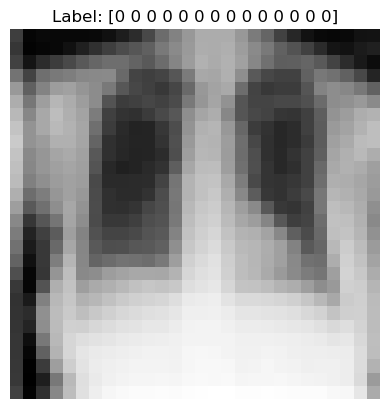

label_names: {'0': 'atelectasis', '1': 'cardiomegaly', '2': 'effusion', '3': 'infiltration', '4': 'mass', '5': 'nodule', '6': 'pneumonia', '7': 'pneumothorax', '8': 'consolidation', '9': 'edema', '10': 'emphysema', '11': 'fibrosis', '12': 'pleural', '13': 'hernia'}


In [2]:
import matplotlib.pyplot as plt
from medmnist.info import INFO

sample_image = train_dataset.imgs[0]

plt.imshow(train_dataset.imgs[0], cmap='gray')
plt.title(f"Label: {train_dataset.labels[0]}")
plt.axis('off')
plt.show()

label_names = INFO['chestmnist']['label']

print(f"label_names: {label_names}")

Now we can see a single image and the label names for the 14 classes. The image is fairly blurry but that is expected. This dataset is built for educational purposes and resolutions are kept intentionally low for ease of use. The selected first image has 0's for all of the labels, this indicates that none of the conditions are present in the image.

---

The following step is not usually recommended or required. In order to provide a better example of using tensorflow datasets, we will store the images to disk and then handle them with a tensorflow dataset.

In [3]:
import os
from pathlib import Path
import pandas as pd
from tqdm import tqdm

DATASET_DIR = Path("../Data/MedMNIST/ChestMNIST")


for split in ['train', 'val', 'test']:
    print(f"Processing {split} dataset...")

    labels = []
    
    split_dir = DATASET_DIR / split
    split_dir.mkdir(parents=True, exist_ok=True)

    existing_files = set(os.listdir(split_dir))
    existing_ids = [int(f.split('.')[0]) for f in existing_files]

    for i, (image, label) in tqdm(enumerate(ChestMNIST(split=split)), total=len(ChestMNIST(split=split))):
        id = i
        image_path = Path(split_dir / f"{id}.png")
        if not id in existing_ids:
            plt.imsave(image_path, image, cmap='gray')
        id_label = [id] + label.tolist()
        labels.append(id_label)
    

    #create the labels dataframe    
    columns = ["id"]
    for label in range(len(label_names)):
        label_name = label_names[str(label)]
        columns.append(label_name)

    labels_df = pd.DataFrame(labels, columns=columns)

    # save labels to csv
    label_csv_path = DATASET_DIR / f"{split}.csv"
    labels_df.to_csv(label_csv_path, index=False)


Processing train dataset...


100%|██████████| 78468/78468 [00:48<00:00, 1634.69it/s]


Processing val dataset...


100%|██████████| 11219/11219 [00:01<00:00, 10347.08it/s]


Processing test dataset...


100%|██████████| 22433/22433 [00:03<00:00, 6560.53it/s]


## 2. Dataset Definition

In comparison to other datasets, image data can be a bit more complex to work with. Images pose a couple of unique challenges:

1. Images are large in size, you usually can't load a full image dataset into memory at once.
2. As a result of the large size, it is common to use data generators to load images into memory. This allows us to wait to load the image into memory until it is being loaded into a batch for training. That way we never have more images in memory than our batch size. We can also use the loading process to handle data augmentation (scaling, rotation, etc.).

Tensorflow offers helpful classes for loading image data. One of the most useful is [image_dataset_from_directory](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory), however, by default it is built to support binary or multi-class classification. We have to adapt a couple parameters to support our multi-label classification task.



In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

BATCH_SIZE = 32
IMAGE_SIZE = (28, 28)

datasets = {}
labels = {}

for split in ['train', 'test', 'val']:
    #get the labels
    label_csv_path = DATASET_DIR / f"{split}.csv"
    labels_df = pd.read_csv(label_csv_path)
    labels[split] = labels_df
    # Convert labels to numpy array, dropping the 'id' column
    labels_array = labels_df.drop(columns=['id']).to_numpy(dtype=np.float32)
    print(labels_array.shape)
    labels_dataset = tf.data.Dataset.from_tensor_slices(labels_array) #Usually datasets can be created directly, however this extra step is necessary for multi-label classification

    #build the dataset
    image_dir  = DATASET_DIR / split
    
    print(f"Building dataset for {split}...")
    images_dataset = image_dataset_from_directory(
        image_dir,
        batch_size=None,
        image_size=IMAGE_SIZE,
        label_mode='categorical', #multi-label classification
        class_names=label_names, #not necessary but helpful for evaluation
        labels=None #multi-label classification we will have to supply the labels separately
    )

    #zip the images and labels together
    dataset = tf.data.Dataset.zip((images_dataset, labels_dataset))
    dataset = dataset.batch(BATCH_SIZE)
    datasets[split] = dataset

(78468, 14)
Building dataset for train...


Now lets test that the dataset is working as expected. We will print out the first 9 images and their labels.

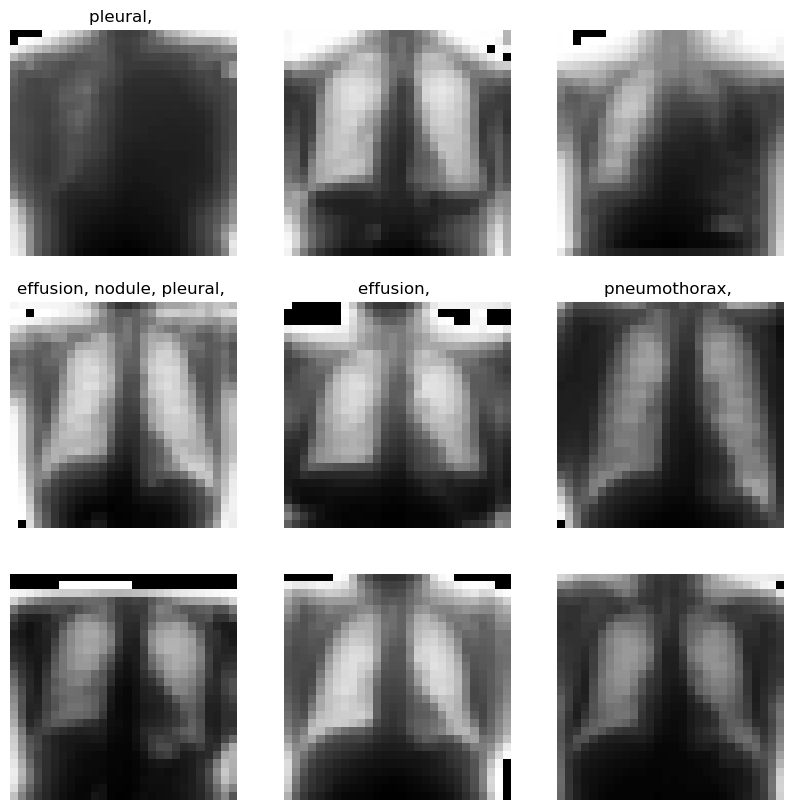

In [ ]:
import matplotlib.pyplot as plt

def labels_to_string(labels, label_names):
  labels_string = ""
  for j in range(len(label_names)):
    if labels[j] == 1: #if the label is 1, print the label name
      labels_string += label_names[str(j)] + ", "
  return labels_string  

plt.figure(figsize=(10, 10))

for images, labels in datasets['val'].take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    #reverse scaling
    image = images[i].numpy() * 255.0
    image = image.astype(np.uint8)
    plt.imshow(image)
    #print the label names
    labels_string = labels_to_string(labels[i].numpy(), label_names)
    plt.title(labels_string)
    plt.axis("off")

### 2.1. Data Transformations

Often times we will want to transform the image before passing it into the model. Here are three reasons why you may need image transformation.

1. **Normalization** - Normalize the pixel values to be between 0 and 1.
2. **Resizing** - Resize the image to a different size.
3. **Augmentation** - Rotate, scale, flip, crop, etc. to artificially increase the size of the dataset. Augmentation also can improve the model's ability to generalize. This should only be done on the training data, the validation and test data should not be augmented.

In tensorflow, we can apply transformations to the images through the map function.




In [32]:
import tensorflow as tf

def transform_train_image(image, label):
    #convert to grayscale
    image = tf.image.rgb_to_grayscale(image)
    #resize the image
    image = tf.image.resize(image, IMAGE_SIZE)
    #normalize the image
    image = tf.cast(image, tf.float32) / 255.0

    #augment the image
    image = tf.image.random_flip_left_right(image)

    return image, label

def transform_eval_image(image, label):
    #convert to grayscale
    image = tf.image.rgb_to_grayscale(image)
    #resize the image
    image = tf.image.resize(image, IMAGE_SIZE)
    #normalize the image
    image = tf.cast(image, tf.float32) / 255.0

    return image, label

for split, dataset in datasets.items():
    if split == 'train':
        datasets[split] = dataset.map(lambda x, y: transform_train_image(x, y))
    else:
        datasets[split] = dataset.map(lambda x, y: transform_eval_image(x, y))


Finally, we can add a cache and prefetch to the dataset to improve performance.


In [33]:
AUTOTUNE = tf.data.AUTOTUNE

for split, dataset in datasets.items():
    if split == 'train':
        datasets[split] = dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
    else:
        datasets[split] = dataset.cache().prefetch(buffer_size=AUTOTUNE)


## 3. Model Architecture

First we will build a basic CNN model containing a single convolutional layer and a dense output layer.


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

#set hyperparameters
NUM_FILTERS = 32
KERNEL_SIZE = (3, 3)
CONV_ACTIVATION = 'relu'
POOL_SIZE = (2, 2)
DENSE_ACTIVATION = 'sigmoid' #multi-label classification, this is not the best choice for multi-class or binary classification

#build the model
model = Sequential([
    Conv2D(NUM_FILTERS, KERNEL_SIZE, activation=CONV_ACTIVATION, input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 1)), # 1 channel for grayscale
    MaxPooling2D(POOL_SIZE),
    Flatten(),  
    Dense(len(label_names), activation=DENSE_ACTIVATION)
])

model.summary()



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 5408)              0         
                                                                 
 dense_1 (Dense)             (None, 14)                75726     
                                                                 
Total params: 76,046
Trainable params: 76,046
Non-trainable params: 0
_________________________________________________________________


## 4. Model Training
Now we will fit the model to the training data. We will use early stopping based on feedback from the validation set. This is a simple way to prevent overfitting.

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Check for GPU availability
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("\nGPU Devices:")
for gpu in tf.config.list_physical_devices('GPU'):
    print(gpu)


EPOCHS = 1000 # Set high because we will use early stopping
EARLY_STOPPING_PATIENCE = 10 # If no improvement seen in 10 epochs, stop training
OPTIMIZER = 'adam'
LOSS = 'binary_crossentropy' #multi-label classification
METRICS = ['accuracy', 'AUC'] 

model.compile(optimizer=OPTIMIZER,
              loss=LOSS,
              metrics=METRICS)

early_stopping = EarlyStopping(monitor='val_auc', patience=EARLY_STOPPING_PATIENCE, restore_best_weights=True)

#history = model.fit(datasets['train'], validation_data=datasets['val'], epochs=EPOCHS, callbacks=[early_stopping])



Epoch 1/1000
